In [2]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud
import re

## Reviews download
https://pypi.org/project/steamreviews/

In [3]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [4]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [5]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [39]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'],  
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", 
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

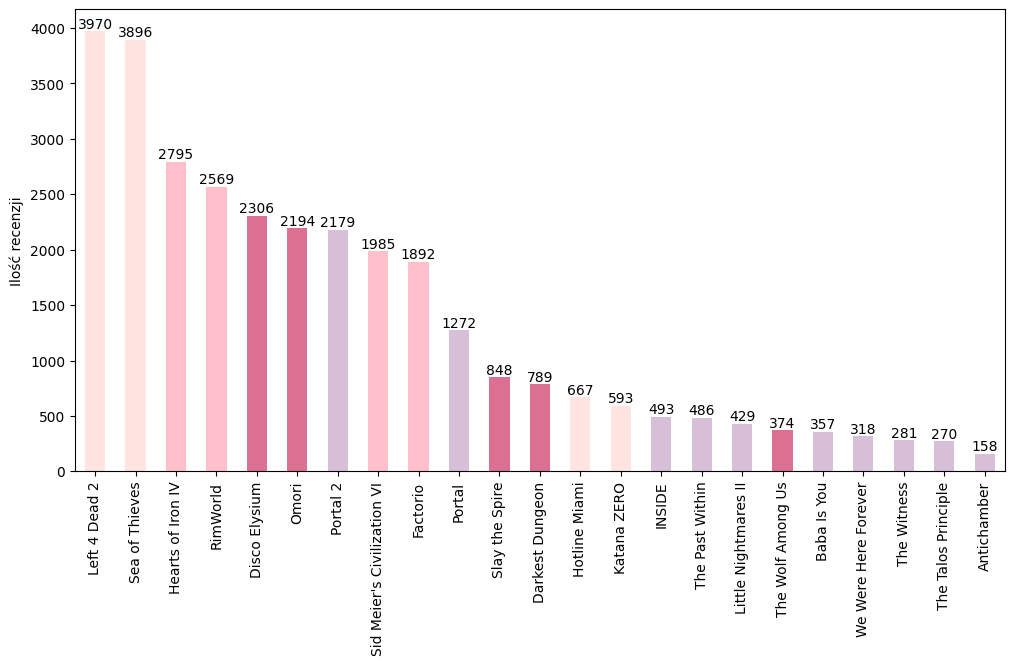

In [40]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": "mistyrose", "R": "palevioletred", "P": "thistle", "S": "pink"}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

plt.show()

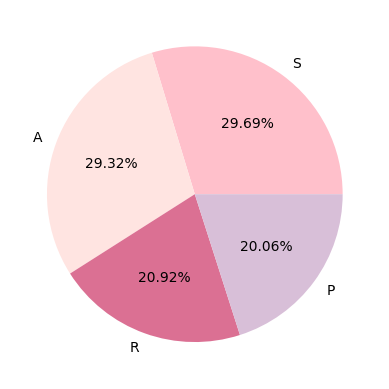

In [41]:
value_counts_genre = df["genre"].value_counts()
colors = ["pink", "mistyrose", "palevioletred", "thistle"]
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

In [42]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews,timestamp_created,color
9010,Darkest Dungeon,R,76561198022679039,1,"Genuine masterpiece, one of the best games in ...",0.523809552192687988,271,1709,44,1673272398,palevioletred
27896,Disco Elysium,R,76561198844669471,3,I'm a communist now,0.52899467945098877,101,571,9,1667395042,palevioletred
27847,Disco Elysium,R,76561198255286848,3,Great game that the publishers clearly haven't...,0.531437695026397705,0,428,7,1679615978,palevioletred
10265,Sid Meier's Civilization VI,S,76561198041412626,1,What to say... Masterpiece? Must-have for all ...,0.523809552192687988,0,6355,2,1673447558,pink
28927,Disco Elysium,R,76561198066640538,2,Great game.,0.517117023468017578,0,754,110,1689253515,palevioletred


In [43]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
3. Usunięcie recenzjii osób, które grały mniej niż godzinę w momencie publikacji recenzji
4. Usunięcie recenzjii krótszych niż 4 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
7. Tokenizacja
10. Correct misspelled word
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [44]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
color                  0
dtype: int64

#### Usunięcie duplikatów

In [56]:
df.duplicated(subset='review').sum()

2523

In [57]:
df[df.duplicated(subset='review')].sample(59)

,title,genre,steamid,votes_up,review,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews,timestamp_created,color
25851,Portal 2,P,76561199220059771,1,yes,0.523809552192687988,0,34,20,2023-03-30 15:34:12,thistle
3856,Sea of Thieves,A,76561198198070790,1,pirate game,0.523809552192687988,0,5903,2,2023-03-11 15:38:30,mistyrose
23845,Left 4 Dead 2,A,76561198798935429,1,fun,0.523809552192687988,0,19514,1,2022-10-17 12:38:21,mistyrose
16122,Hearts of Iron IV,S,76561198999625702,1,good,0.52173912525177002,0,3677,3,2023-03-16 21:41:59,pink
30110,Slay the Spire,R,76561199013963819,1,I fucking suck at this game,0.519999980926513672,41,903,8,2023-09-22 02:45:16,palevioletred
26203,Portal 2,P,76561198328086517,1,yes,0.523809552192687988,0,237,8,2023-01-03 21:26:21,thistle
19222,Factorio,S,76561198323020005,1,crack,0.523809552192687988,0,3899,2,2023-07-02 07:59:47,pink
28061,Disco Elysium,R,76561198799988834,1,literally me,0.523809552192687988,137,2688,11,2023-09-16 06:27:52,palevioletred
24191,Left 4 Dead 2,A,76561199445637179,1,gg,0.52173912525177002,0,191,2,2022-12-24 00:17:02,mistyrose
1004,Omori,R,76561198392836380,1,i cried,0.523809552192687988,38,2149,18,2023-03-04 19:07:21,palevioletred


In [58]:
(df.duplicated(subset='review') == False).sum()

28598

In [59]:
df = df[df.duplicated(subset='review') == False]

In [60]:
df.duplicated(subset='review').sum()

0

#### Czas gry mniejszy od godziny

In [61]:
df["playtime_at_review"] = df["playtime_at_review"] / 60

In [62]:
value_counts_hour_playtime = df[df["playtime_at_review"] <1]["title"].value_counts()

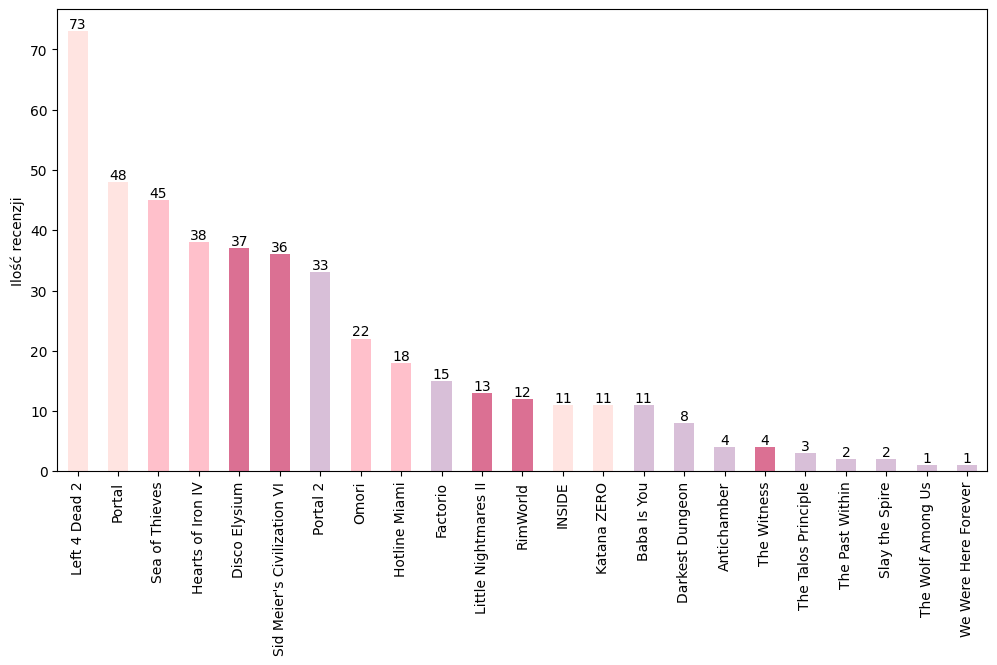

In [63]:
genre_colors = {"A": "mistyrose", "R": "palevioletred", "P": "thistle", "S": "pink"}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_hour_playtime.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_hour_playtime):
    x.text(i, count, count, va = "bottom", ha = "center")

plt.show()

In [64]:
df = df[df["playtime_at_review"]>1]

#### Długość recenzji

In [65]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    28132.000000
mean        53.449097
std        134.085936
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [66]:
df[df["temp_review_len"] == df["temp_review_len"].max()]['review'].values

array(['t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y m u s t g r o w t h e f a c t o r y 

In [67]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews,timestamp_created,color,temp_review_len
genre,,,,,,,,,,,
A,1621,1621,1621,1621,1621,1621,1621,1621,1621,1621,1621
P,796,796,796,796,796,796,796,796,796,796,796
R,778,778,778,778,778,778,778,778,778,778,778
S,1124,1124,1124,1124,1124,1124,1124,1124,1124,1124,1124


In [68]:
df = df[df["temp_review_len"] > 4]

In [69]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [70]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1488634 Ilość recenzji: 22272


### Wordcloud

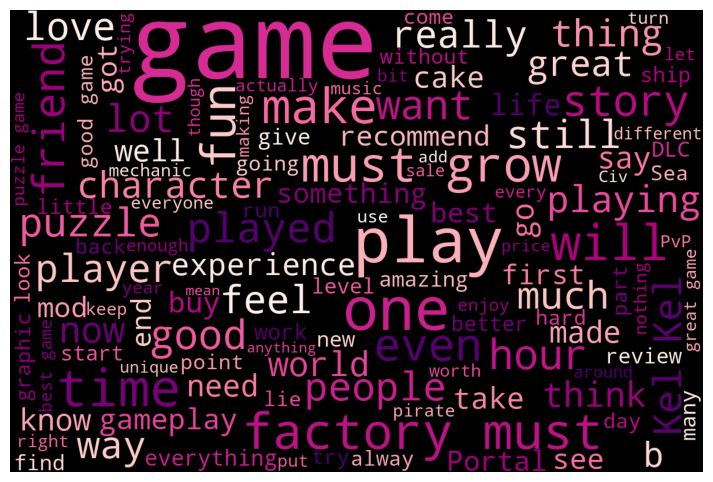

In [71]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

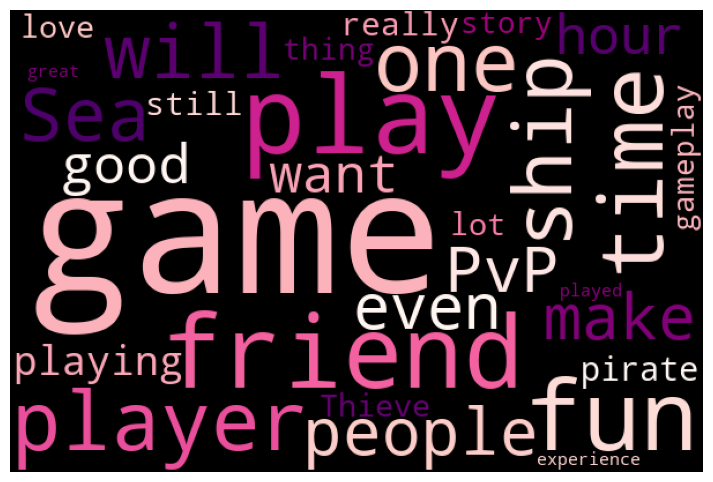

In [72]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

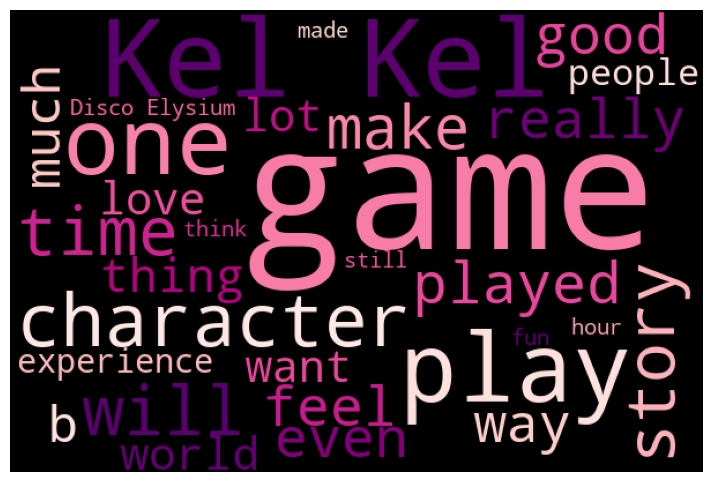

In [73]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

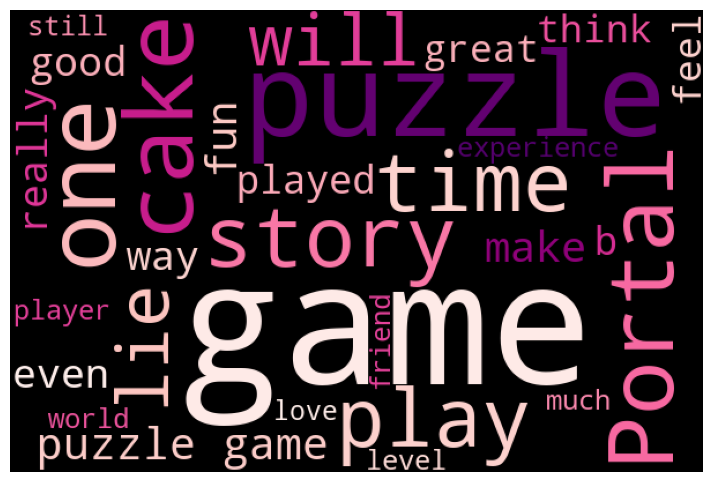

In [74]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

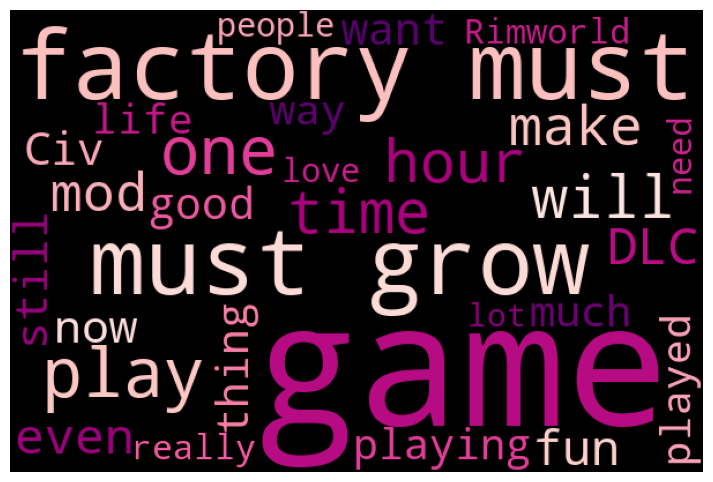

In [75]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [76]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [77]:
df["review"].sample(5)

3073     great fun game terrible community they will ju...
3337                                lots of boom and chaos
29398    i'm make this quick. i love this game so much,...
802                    i'll forgive you basil, no worries.
10031    fantastic game, been playing the franchise for...
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [78]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [79]:
import string 
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [80]:
df["review"].sample(5)

3390     good game i just got this game and im surprise...
24119    the game is good but the community is atrociou...
26621    great game but i was honestly expecting some c...
6772     the past within is a great game  played with a...
7389                   i like hurting other people rooster
Name: review, dtype: object

#### Tokenizacja

In [81]:
import nltk
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [82]:
df["tokenized"].sample(15)

27736    [probably, the, most, important, game, of, the...
8152     [if, youve, played, and, enjoyed, a, telltale,...
30894    [really, touching, story, with, an, astonishin...
8809     [i, didnt, really, understand, the, criticism,...
9367     [the, negative, reviews, are, over, a, transla...
12429    [its, really, the, only, problem, is, i, get, ...
8337     [youre, not, as, bad, as, everyone, says, you,...
17086    [needs, to, be, a, feature, allowing, you, to,...
18517    [portal, is, a, first, person, puzzle, platfor...
18638    [better, than, sex, would, recommend, disclaim...
17796    [i, dont, think, the, portal, series, needs, t...
24726    [nearly, k, hrs, and, i, get, bullied, every, ...
19888    [i, hate, this, game, so, much, please, send, ...
6265     [really, enjoyed, the, game, my, wife, and, i,...
7300     [one, of, the, absolute, best, games, of, the,...
Name: tokenized, dtype: object

#### POS tagging

In [83]:
nltk.download('averaged_perceptron_tagger')
df["tagged"] = df["tokenized"].apply(nltk.pos_tag)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Correct misspelled word

#### Lematyzacja